## 01. PyTorch Workflow Fundamentals

- https://www.learnpytorch.io/01_pytorch_workflow/

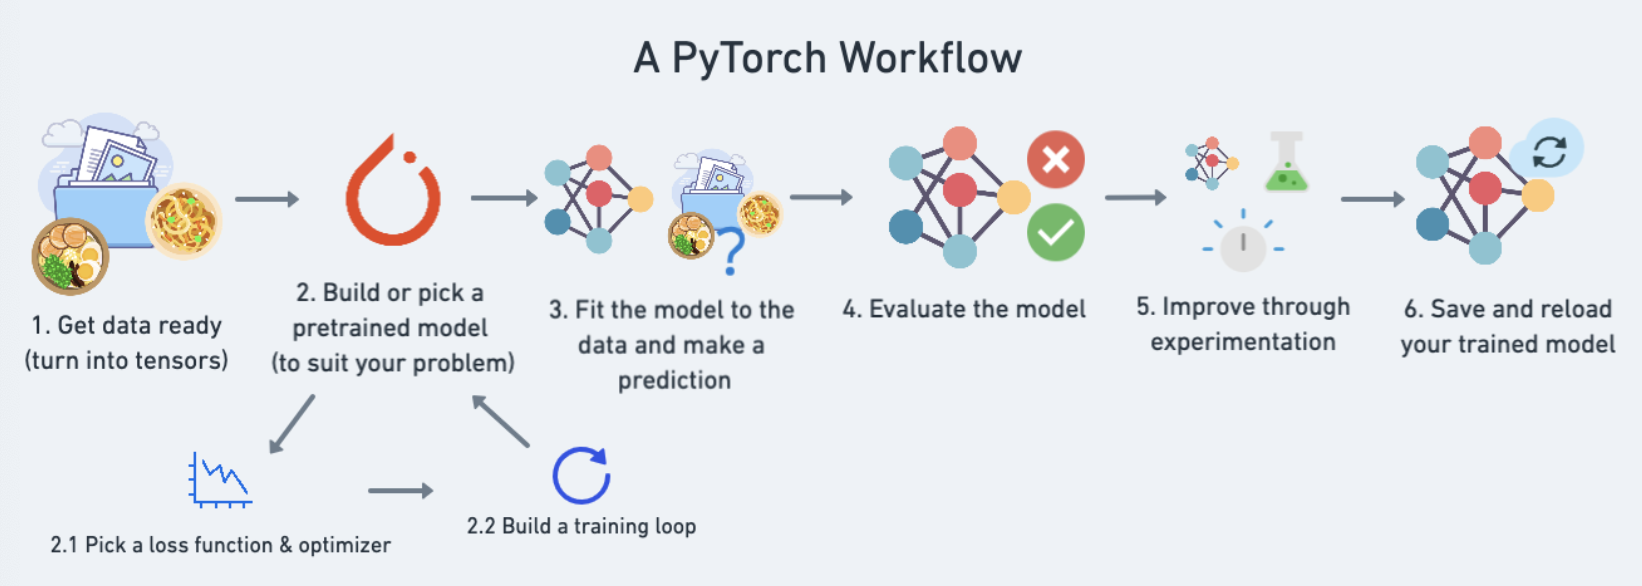

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1'

### 1. Data : preparing and loading

데이터 만들기

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X)

50

데이터 나누기

In [5]:

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

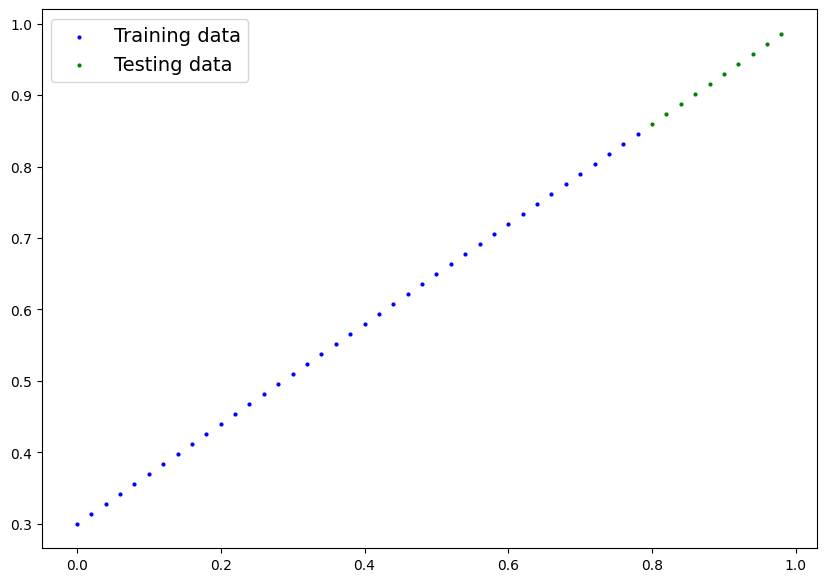

In [7]:
plot_predictions()

### 2. Build model

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # 랜덤으로 초기화 
                                                dtype= torch.float), # 디펄트 flaot은 float32 
                                                requires_grad = True) 
        self.bias = nn.Parameter(torch.randn(1, dtype = torch.float),
                                            requires_grad=True)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

모델관련 주요 파라미터  
- torch.nn : 신경망 모듈
- torch.nn.Parameter : nn.Module 안에서 모델을 구성할 파라미터 정의에 사용  
- torch.nn.Module : 상속받아 클래스 구현
- torch.optim : 옵티마이저
- def forward()

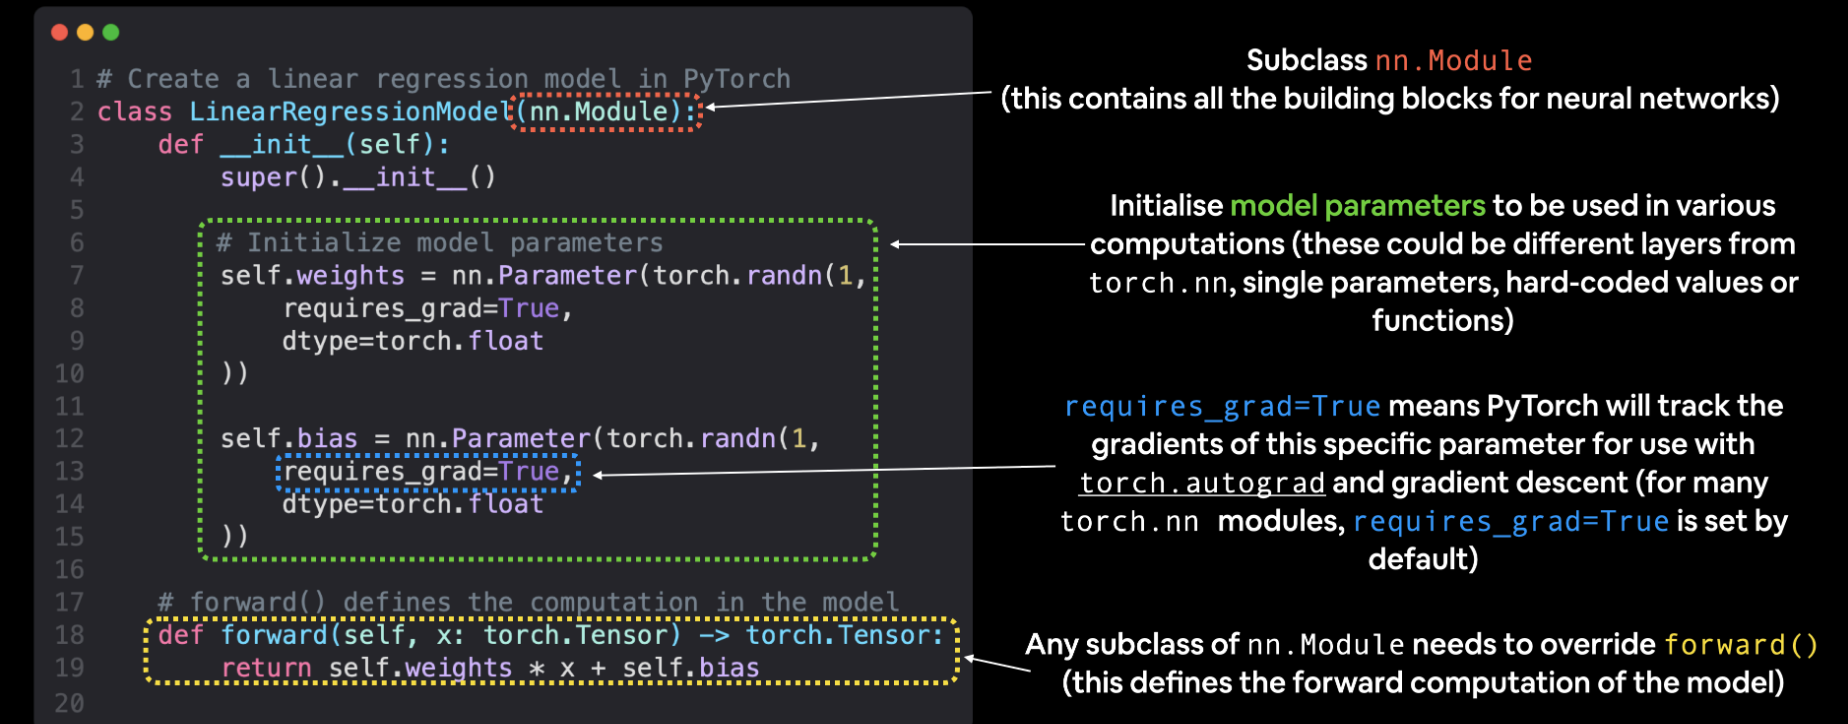

모델 확인

In [9]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
model_0

LinearRegressionModel()

In [10]:
model_0.parameters()

<generator object Module.parameters at 0x1414b6580>

In [11]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

state_dict()로도 확인가능

In [12]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

torch.inference_mode() : 추론할 때 사용. foward 메서드가 호출됨. 다른 설정을 off하여 포워드 패스를 빠르게 한다.

In [13]:
with torch.inference_mode():
    y_preds = model_0(X_test)
    
# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [14]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

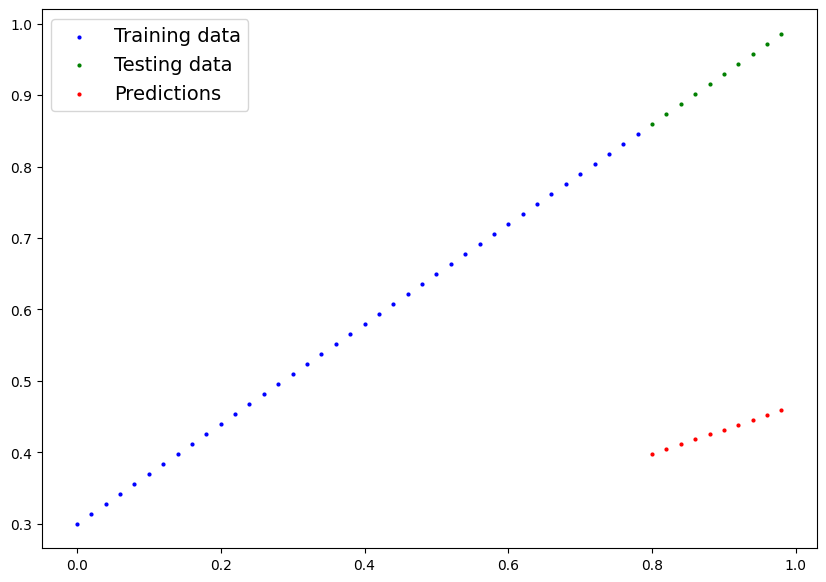

In [15]:
plot_predictions(predictions=y_preds)

### Train model

손실함수, 옵티마이저 만들기

- 손실함수 : Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()). Binary cross entropy for binary classification problems (torch.nn.BCELoss()).    
- 옵티마이저 : Stochastic gradient descent (torch.optim.SGD()). Adam optimizer (torch.optim.Adam()).

In [16]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr = 0.01)

pytorch training loop

- forward pass : model(x_train)
- calculate the loss : loss = loss_fn(y_pred, y_train)
- zero gradient : optimizer.zero_grad(), 매 학습 스탬마다 다시 계산을 위해 0으로 설정
- perform backpropagation on the loss : loss.backward()
- update the optimizer(gradient decent) : optimizer.step()

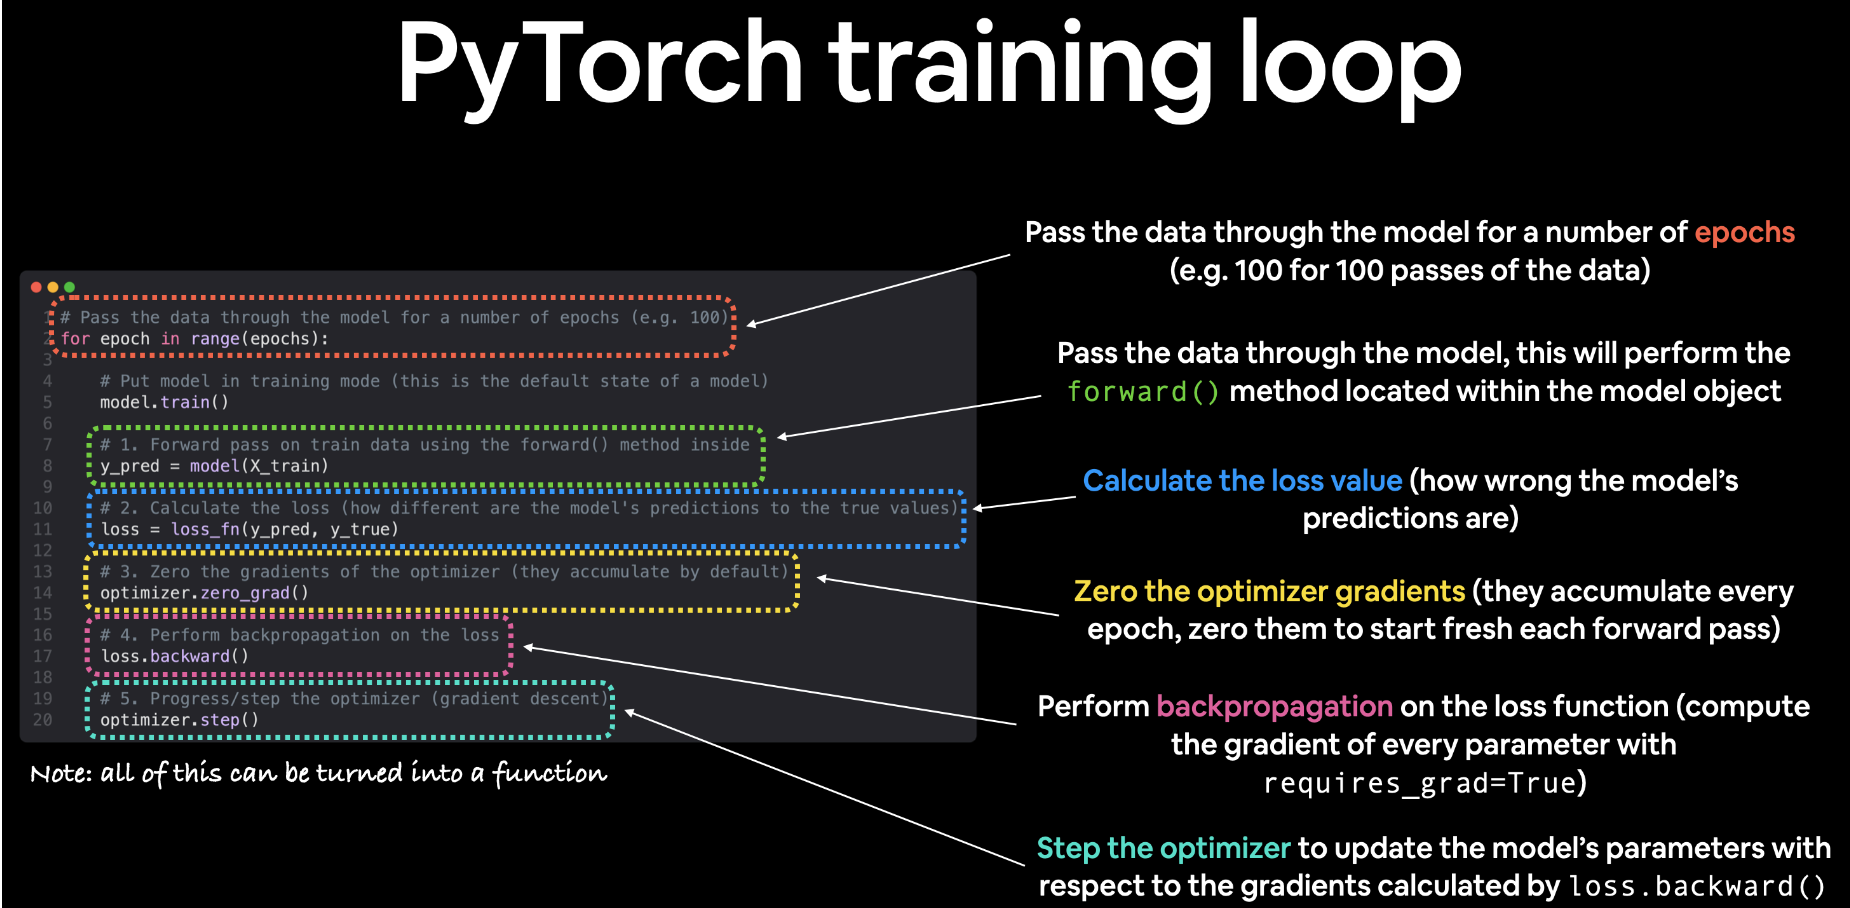

- Calculate the loss (loss = ...) before performing backpropagation on it (loss.backward()).
- Zero gradients (optimizer.zero_grad()) before stepping them (optimizer.step()).
- Step the optimizer (optimizer.step()) after performing backpropagation on the loss (loss.backward()).

testing loop

- forward pass : model(x_test)
- calculate the loss : loss = loss_fn(y_pred, y_test)
- calculate evaluation metrics(optional) : custom functions

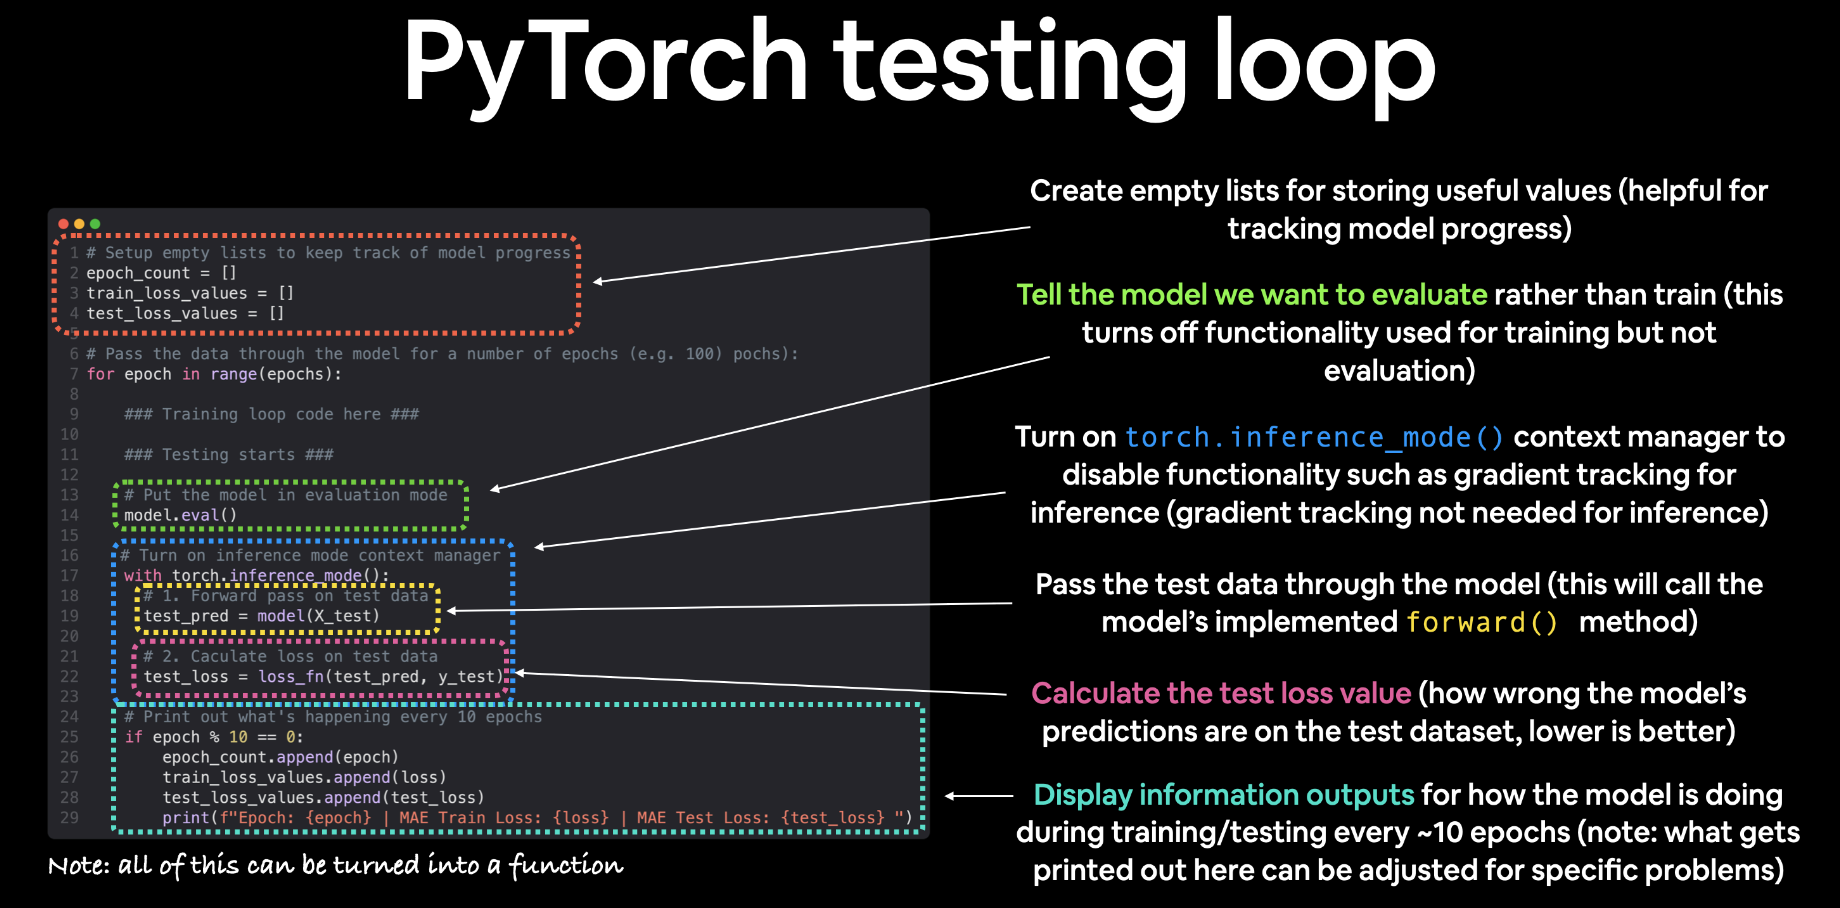

In [17]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()
    
    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788740023970604 | MAE Test Loss: 0.06473556160926819 


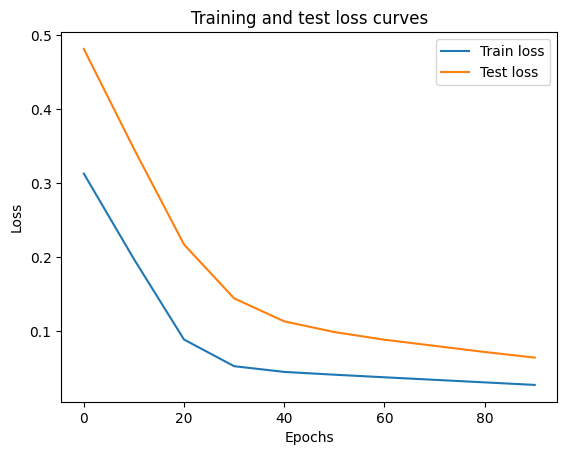

In [18]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [19]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 4. Making predictions with a trained PyTorch model (inference)

In [20]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

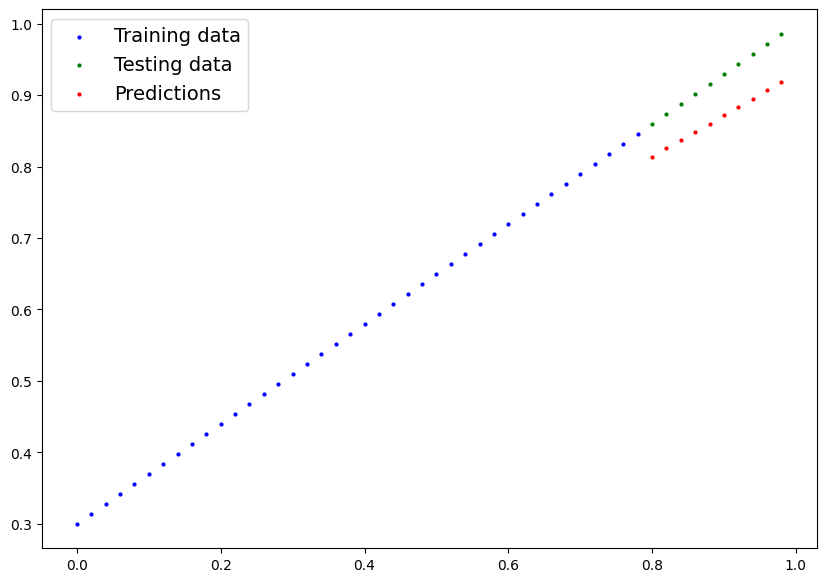

In [21]:
plot_predictions(predictions=y_preds)

### 5. Saving and loading a PyTorch model

- torch.save : Saves a serialzed object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.   
- torch.load : Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).  
- torch.nn.Module.load_state_dict : Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

state_dict()로 모델 저장, 로드하기가 추천됨

- https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

- 1. We'll create a directory for saving models to called models using Python's pathlib module.
- 2. We'll create a file path to save the model to.
- 3. We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.

일반적으로 파이토치 모델을 저장할 때 .pt나 .pth로 저장한다.

In [22]:
from pathlib import Path

# 모델 디렉토리 생성
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 모델 저장 경로 생성
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 모델 state dict 저장
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [23]:
!ls

 07. PyTorch Experiment Tracking.ipynb
00.pytorch fundamentals.ipynb
01. PyTorch Workflow Fundamentals.ipynb
02. Pytorch Neural Network Classification.ipynb
03. PyTorch Computer Vision.ipynb
04. PyTorch Custom Datasets.ipynb
05.Going_Modular
06. PyTorch Transfer Learning.ipynb
08. PyTorch Paper Replicating.ipynb
2023-06-08-18-11-58.png
__pycache__
data
helper_functions.py
models
runs


저장된 모델의 state_dict() 로딩하기   
- torch.nn.Module.load_state_dict(torch.load(f))를 호출하면 된다. 여기서 f는 파일 경로  
- 그러면 torch.nn.Module.load_state_dict()안에 왜 torch.load()를 호출할까?
- 왜냐하면 우리는 모델 전체가 아닌 state_dict()만 저장했기 때문에 torch.load()로 state_dict를 호출해야 한다.  
- 이렇게 하면 state_dict를 새로운 모델 인스턴스에 주입한다.

왜 전체모델을 저장하지 않을까?  
전체 모델을 저장하는 것이 공식문서에는 다음과 같이 설명되어 있다.  

- 이 접근 방식(전체 모델 저장)의 단점은 직렬화된 데이터가 특정 클래스와 모델을 저장할 때 사용된 정확한 디렉토리 구조에 바인딩된다는 것입니다.
- 이 때문에 다른 프로젝트에서 사용하거나 리팩터링 후에 사용할 때 코드가 여러 가지 방식으로 깨질 수 있습니다.   

그래서 대신 기본적으로 모델 매개변수의 딕셔너리인 state_dict()만 저장하고 로드하는 유연한 방법을 사용하고 있다.

In [24]:
model_0

LinearRegressionModel()

In [25]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [26]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

이제 로딩한 데이터로 평가를 진행해보자.

In [27]:
loaded_model_0.eval() # 모델을 eval 모드로 설정

with torch.inference_mode(): # 예측을 위해 인퍼런스 모드 사용
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass

In [28]:
y_preds == loaded_model_preds # 저장 전후 모델의 예측결과 비교

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

- 더 자세한 내용은 아래 경로에서 확인
- https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models

### 6. Putting it all together   
처음부터 내려가며 다시 진행해보자.

In [29]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.1'

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

Using device cpu


Data

In [31]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [32]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

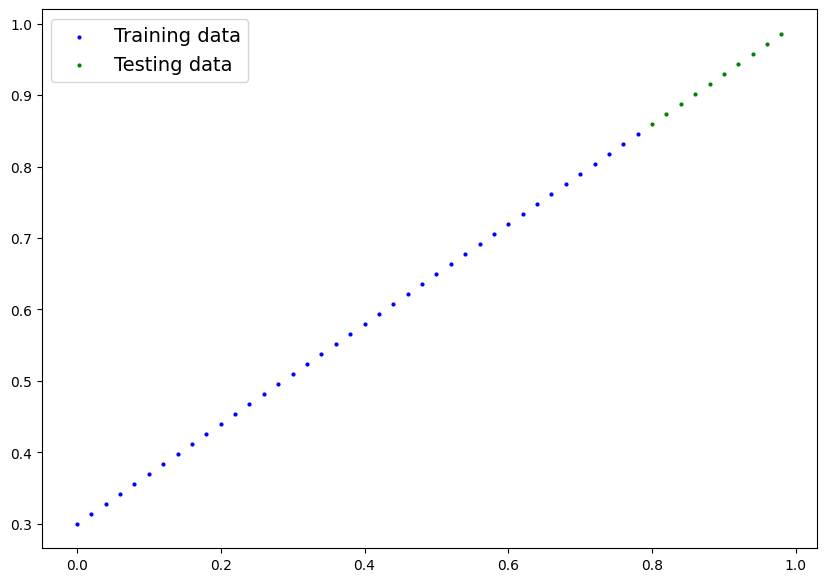

In [33]:
plot_predictions(X_train, y_train, X_test, y_test)

모델 만들기

여기서는 nn.Parameter() 대신에 nn.Linear()를 사용한다.

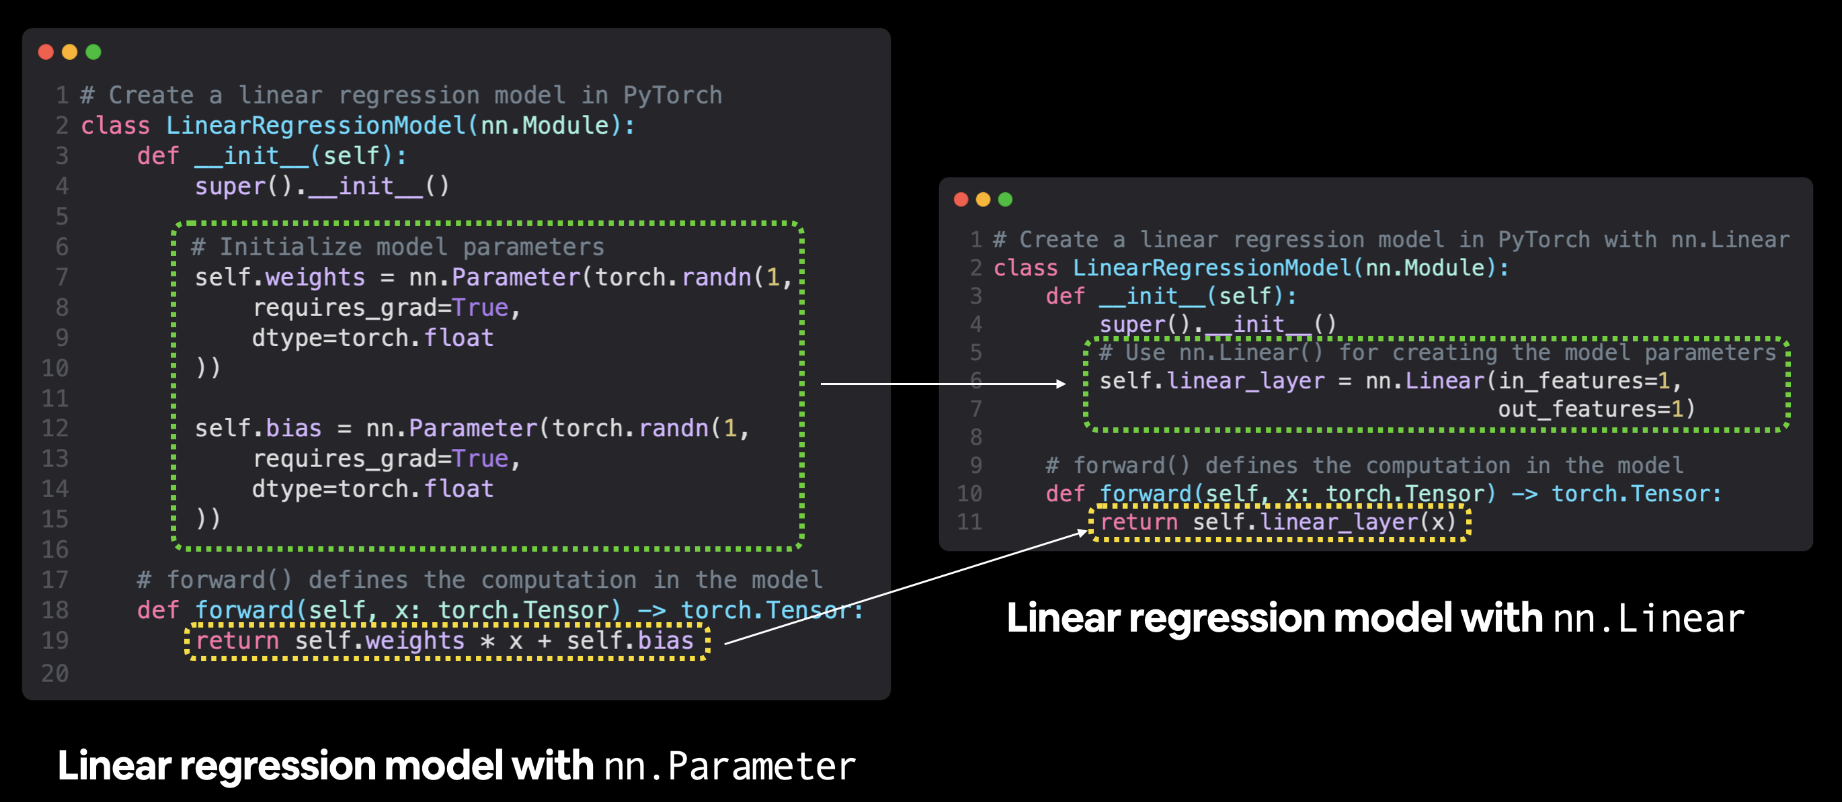

In [34]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                     out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [35]:
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()

In [36]:
model_1

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [37]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

현재 모델의 디바이스를 확인한다.

In [38]:
next(model_1.parameters()).device

device(type='cpu')

만약 gpu가 있다면 to(device) 사용

In [39]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [40]:
device

'cpu'

Training

In [41]:
# 손실함수
loss_fn = nn.L1Loss()

# 옵티마이저
optimizer = torch.optim.SGD(params=model_1.parameters(),
                           lr = 0.01)

In [42]:
torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
    # 학습
    model_1.train()
    
    y_pred = model_1(X_train) # 1 forward pass
    
    loss = loss_fn(y_pred, y_train) # 2. calc loss
    
    optimizer.zero_grad() # 3. zero grad optimizer
    
    loss.backward() # 4. loss backward
    
    optimizer.step() # 5. step the optimizer
    
    # 테스트
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645028764382005 | Test loss: 0.013801807537674904


In [43]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


예측해보기

In [44]:
model_1.eval()

with torch.inference_mode():
    y_preds =  model_1(X_test)

In [45]:
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

이제 차트를 그려보자.  
pandas, numpy, matplotlib 같은 라이브러리는 GPU에 저장된 데이터를 사용할 수없다.   
따라서 데이터가 cpu에 저장되어 있지 않다면 .cpu()함수를 호출해야 한다.

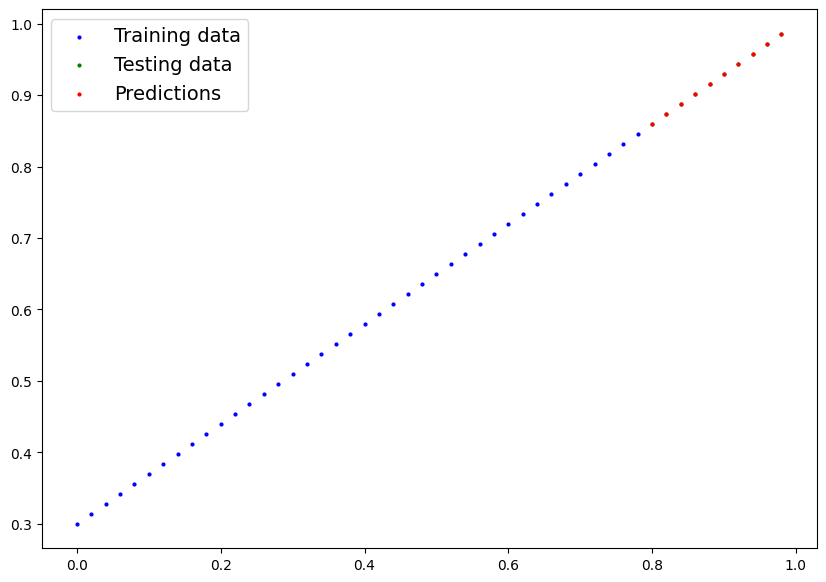

In [46]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

모델 저장

In [47]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


이제 새로운 모델 인스턴스를 생성하고, 파라미터를 불러와서 테스트 해본다.

In [48]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [49]:
print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [50]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])